# CNN for pulmonary disease image classification (multi-class)
## author: Dr. Reynier Cruz Torres

## Data source and details:
https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
npixels = 256
do_training = True

In [3]:
gen_train = ImageDataGenerator(rescale=1./255,validation_split = 0.)

train = gen_train.flow_from_directory('./data/train',
                                      target_size = (npixels,npixels),
                                      batch_size = 40,
                                      class_mode = 'categorical',
                                      color_mode = 'grayscale',
                                      shuffle = True,
                                      seed = 42,
                                      subset = 'training')

Found 251 images belonging to 3 classes.


In [4]:
classes=pd.DataFrame(train.classes)
classes.value_counts()

0    111
1     70
2     70
dtype: int64

In [5]:
classes = train.class_indices

In [6]:
gen_test = ImageDataGenerator(rescale=1./255,validation_split = 0.)

test = gen_test.flow_from_directory('./data/test',
                                    target_size = (npixels,npixels),
                                    batch_size = 15,
                                    class_mode = 'categorical',
                                    color_mode = 'grayscale',
                                    shuffle = True,
                                    seed = 42,
                                    subset = 'training')

Found 66 images belonging to 3 classes.


### Defining model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dense, Dropout

model = Sequential()

model.add(InputLayer(input_shape=(npixels,npixels,1)))

model.add(Conv2D(filters=32,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))

model.add(Dense(3, activation="softmax"))

model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dropout (Dropout)           (None, 262144)            0

### Training model

In [8]:
if do_training:
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights = True)
    
    model.fit(train,verbose=1,callbacks = [early_stop],epochs=50,validation_data=(test))
    model.save('my_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('my_model.h5')

Epoch 1/50


2023-01-10 19:52:07.247740: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


7/7 [==============================] - 9s 1s/step - loss: 0.8968 - accuracy: 0.6733 - val_loss: 9.4580 - val_accuracy: 0.3182
Epoch 2/50
7/7 [==============================] - 8s 1s/step - loss: 0.6041 - accuracy: 0.7849 - val_loss: 10.4664 - val_accuracy: 0.3182
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.4065 - accuracy: 0.8406 - val_loss: 10.7691 - val_accuracy: 0.3030
Epoch 4/50
7/7 [==============================] - 8s 1s/step - loss: 0.2902 - accuracy: 0.8725 - val_loss: 8.6085 - val_accuracy: 0.3030
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 0.2520 - accuracy: 0.9203 - val_loss: 5.6525 - val_accuracy: 0.3030
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 0.2173 - accuracy: 0.9203 - val_loss: 5.4206 - val_accuracy: 0.3182
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 0.1975 - accuracy: 0.9163 - val_loss: 5.0552 - val_accuracy: 0.3788
Epoch 8/50
7/7 [==============================] - 

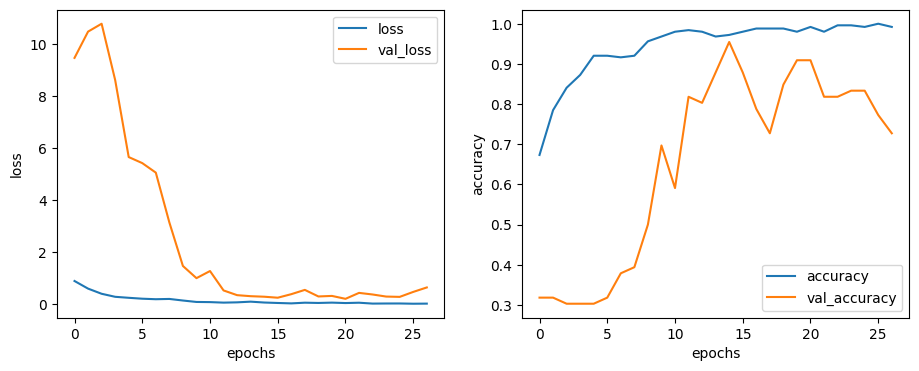

In [9]:
if do_training:
    fig, ax = plt.subplots(ncols=2,figsize=(11,4))
    history = pd.DataFrame(model.history.history)
    
    history[['loss','val_loss']].plot(ax=ax[0])
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    
    history[['accuracy','val_accuracy']].plot(ax=ax[1])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')

### Evaluating a few predictions by hand

Found 66 images belonging to 3 classes.
1/1 [==============================] - 0s 68ms/step


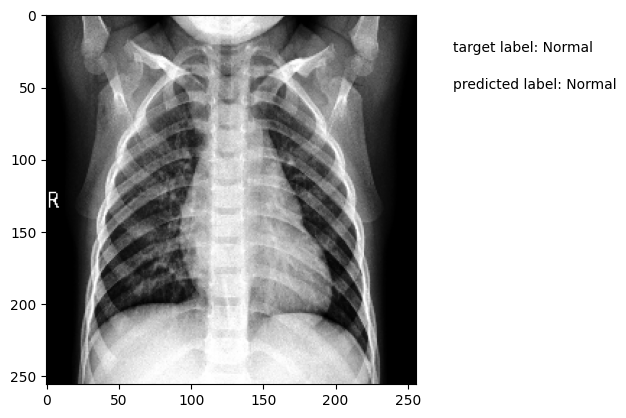

1/1 [==============================] - 0s 17ms/step


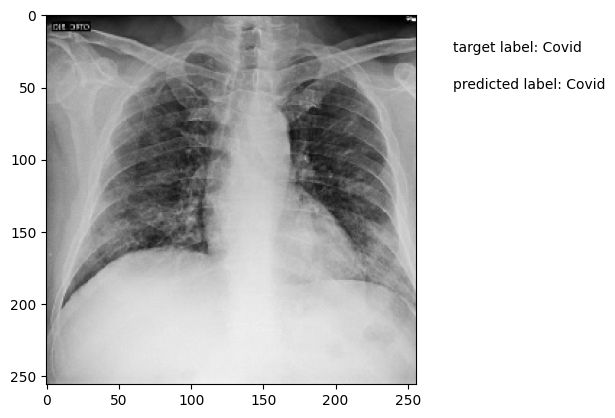

1/1 [==============================] - 0s 16ms/step


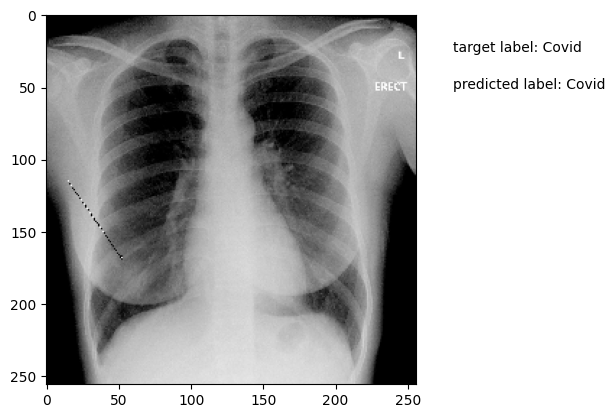

In [10]:
dir_It = gen_test.flow_from_directory('data/test',
                                 target_size = (npixels,npixels),
                                 batch_size = 1,
                                 class_mode = 'binary',
                                 color_mode = 'grayscale',
                                 seed = 101)

for _ in range(3):
    img, label = dir_It.next()
    pred_lab = model.predict(img).argmax()

    value = [i for i in classes if classes[i]==label][0]
    pred_value = [i for i in classes if classes[i]==pred_lab][0]
    
    plt.imshow(img[0],cmap='gray')
    plt.text(1.1,0.9,'target label: {}'.format(value),transform=plt.gca().transAxes)
    plt.text(1.1,0.8,'predicted label: {}'.format(pred_value),transform=plt.gca().transAxes)
    plt.show()

### Further model-performance evaluation

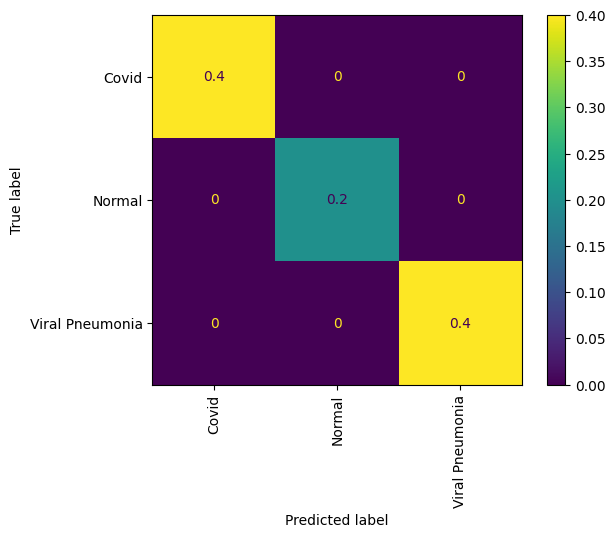

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_test, preds = [], []

for _ in range(len(test)):
    img, label = dir_It.next()
    
    pred_proba = model.predict(img,verbose=0)
    pred = (pred_proba).argmax()
    
    preds.append(pred)
    y_test.append((int)(label[0]))

cm = confusion_matrix(y_test,preds,normalize='all')

ConfusionMatrixDisplay(cm,display_labels=classes).plot(xticks_rotation='vertical')